# This notebook serves as walkthrough for planning an experiment for creation through the OT2.
### The following modules are used and should be in the same directory as this notebook: 
* **CreateSamples** is responsible for calculating sample information, which includes component weight fractions and stock volumes
* **OT2Commands** is responsible for setting up information to be interpretted and executed by opentrons **BASED ON THE LATEST API 2.3 and above**
* **OT2Graphing** contains graphing tools to help visualize and explore parameter spaces.

In [1]:
from Plan import CreateSamples
from Prepare import OT2Commands as ALH
from Prepare import OT2Graphing as ographing
from opentrons import simulate, execute, protocol_api
import importlib
import pandas as pd

In [2]:
importlib.reload(ALH)

<module 'Prepare.OT2Commands' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\PlanPrepareProcess\\Prepare\\OT2Commands.py'>

### Step 1: Set up the experiment dictionary.
The first step to planning an experiment is to load the experiment variables and inputs from a csv file. **Within the Testing Plans Folder you should find a templete of a testing plan (open in Excel for easier viewing).**

Currently the info is split up between two sections: Variables for creating sample spaces and variables for OT2 commands. You only need to specify for the sections you will use.The experiment dictionary consist of keys being the variable name and the value being the variables value. Keep in mind the order of listed variables assumptions should be the index of one listed variable refers to the same index of a related variable.

Besides the plan, if planning on creating a sample space you will need to:
- Update/verify the csv chemical database with/for component information.
- Provide the path of the updated chemical csv for plan. 

In [3]:
path = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Testing Plans\07_30_21_Octadecane_SDS_0pt0005.csv"
chem_path = r"Chemical Database.csv"
plan = CreateSamples.get_experiment_plan(path, chem_path)

### Step 2: Select and Create Sampling Space
The sampling method will depend on the type of sample units, the actual called method (i.e. lattic, non-clustering random..etc) and whether you are providing arguments from the plan in step 1 or importing sample information from elsewhere. 

***Note:*** All information will be stored as a dataframe
 
You can utilize the built in functions in functions to create sample concentration spaces as follows:
- concentration_from_csv: Import csv with headers being component name and concentration unit.
- concentration_from_excel: Import from excel with headers being component name and concentration unit.
- concentration_from_linspace: Pull from plan the linspaces to use lattice or random sampling. Optional: Unity filter allows for last indexed component to be used a completing component. 
- concentration_from_list_samplewise: 
- concentration_from_list_componentwise:
 
**The ONE requirement if you plan to use any of the module functions is you adhere to strict naming convention. This allows the functions to identify key values to use to calculate and determine specific informaiton (i.e. mass, volume to pipette). **

The following conventions are:
- component concentration columns: Should have the term "concentration" and the concentration unit name (i.e. DPPC Concentration Molarity). 
-

In [4]:
concentration_df = CreateSamples.concentration_from_linspace(plan['Component Shorthand Names'], 
                                                             plan['Component Concentration Linspaces [min, max, n]'],
                                                             plan['Component Concentration Units'],
                                                             unity_filter=True)        
concentration_df

,Octadecane concentration wtf,SDS concentration wtf,ethanol concentration wtf,water concentration wtf
0,0.000,0.0005,0.1,0.8995
1,0.000,0.0005,0.2,0.7995
2,0.000,0.0005,0.3,0.6995
3,0.000,0.0005,0.4,0.5995
4,0.000,0.0005,0.5,0.4995
...,...,...,...,...
75,0.001,0.0005,0.4,0.5985
76,0.001,0.0005,0.5,0.4985
77,0.001,0.0005,0.6,0.3985
78,0.001,0.0005,0.7,0.2985


### Step 3: Create Stock Dictionary
The stock dictionary will hold the stock information which will be used to calculate for stock volumes for the OT2.
The stock dictionary function will take 3 main sets of information (all formatted as lists, matched by index). 
- Stock Names: Stock names are to be formatted as solute1-solute2...soluten-solvent-stock i.e. NaCl-water-stock.
    - The solutes and solvents are expected to be in the chemical dictionary provided in step 1 as information such as density and molecular weight will be used in volume calculations.
- Stock Concentration Units: Any conc units supported (see function).
- Stock Concentrations: Value of stock conc.

In [5]:
stock_dict = CreateSamples.stock_dictionary(plan['Stock Names'], 
                                                    plan['Stock Concentration Units'], 
                                                    plan['Stock Concentrations'], stock_densities=plan['Stock Densities (g/mL)'])
stock_dict

{'Octadecane-ethanol-stock': {'solutes': ['Octadecane'],
  'solvents': 'ethanol',
  'unit': 'mgpermL',
  'concentration': 5,
  'Density (g/mL)': 0.789,
  'Common Solvent': 'Mixture'},
 'SDS-ethanol-stock': {'solutes': ['SDS'],
  'solvents': 'ethanol',
  'unit': 'mgpermL',
  'concentration': 10,
  'Density (g/mL)': 0.789,
  'Common Solvent': 'Mixture'},
 'ethanol-stock': {'solutes': [],
  'solvents': 'ethanol',
  'unit': 'wtf',
  'concentration': 1,
  'Density (g/mL)': 0.789,
  'Common Solvent': 'Pure'},
 'water-stock': {'solutes': [],
  'solvents': 'water',
  'unit': 'wtf',
  'concentration': 1,
  'Density (g/mL)': 1,
  'Common Solvent': 'None'}}

### Step 3: Calculate Component Amounts Mass And Volumes
The end goal in this component planning is to calculate for stock volumes, this requires knowledge on the component mass/volumes.

For now there exist one general function *determine_component_amounts* which based on the total amount (either volume or mass) and component conc units will use the appropiate function to calculate for component mass and volume amounts. 

Since this step uses information from the chemical database (density and mw), if that information is missing or not avaible then the resulting values will return as nan. To remove these and replace with zero in cases where the component mass/volume is negligible use the argument within the function to specify a fill amount of nan_fill_value = 0.

In [6]:
complete_amounts_added = CreateSamples.determine_component_amounts(plan, concentration_df, nan_fill_value=0)
complete_amounts_added

You calculated for component masses given the provided units
You calculated for component masses given the provided units
You calculated for component masses given the provided units
You calculated for component masses given the provided units


,Octadecane concentration wtf,SDS concentration wtf,ethanol concentration wtf,water concentration wtf,Octadecane amount mass g,Octadecane amount volume mL,SDS amount mass g,SDS amount volume mL,ethanol amount mass g,ethanol amount volume mL,water amount mass g,water amount volume mL
0,0.000,0.0005,0.1,0.8995,0.0000,0.000000,0.0006,0.000594,0.12,0.152033,1.0794,1.0794
1,0.000,0.0005,0.2,0.7995,0.0000,0.000000,0.0006,0.000594,0.24,0.304067,0.9594,0.9594
2,0.000,0.0005,0.3,0.6995,0.0000,0.000000,0.0006,0.000594,0.36,0.456100,0.8394,0.8394
3,0.000,0.0005,0.4,0.5995,0.0000,0.000000,0.0006,0.000594,0.48,0.608134,0.7194,0.7194
4,0.000,0.0005,0.5,0.4995,0.0000,0.000000,0.0006,0.000594,0.60,0.760167,0.5994,0.5994
...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.001,0.0005,0.4,0.5985,0.0012,0.001544,0.0006,0.000594,0.48,0.608134,0.7182,0.7182
76,0.001,0.0005,0.5,0.4985,0.0012,0.001544,0.0006,0.000594,0.60,0.760167,0.5982,0.5982
77,0.001,0.0005,0.6,0.3985,0.0012,0.001544,0.0006,0.000594,0.72,0.912201,0.4782,0.4782
78,0.001,0.0005,0.7,0.2985,0.0012,0.001544,0.0006,0.000594,0.84,1.064234,0.3582,0.3582


### Step 4: Calculate Volumes of Stocks
From the mass/volume of individual chemical components we calculauted along with the concentration and identities of the provided stocks, we are now able to combine those two pieces of information and obtain the volume of stock needed. 

The general function to use Create.calculate_stock_volumes_from_component_concs will autoamatically use the component information either volume or stock depending on the stock which contains the component and its stock unit. The stock unit essentially determines the pathway of whether component mass or volume will be utilized.See ______ for a map of how specific component concentration untis and stock units pair together to calculate for info. 

Note: This will calculate stock volumes not taking into account any interdepdencies such as common solvents or missing volume to complete a desired sample volume. The next step will have a few cases for which specfic functions can calculate and adjust stock volumes. 

In [7]:
stock_volumes_prelim = CreateSamples.calculate_stock_volumes_from_component_concs(plan, complete_amounts_added, stock_dict)
stock_volumes_prelim

,Octadecane concentration wtf,SDS concentration wtf,ethanol concentration wtf,water concentration wtf,Octadecane amount mass g,Octadecane amount volume mL,SDS amount mass g,SDS amount volume mL,ethanol amount mass g,ethanol amount volume mL,water amount mass g,water amount volume mL,Octadecane-ethanol-stock amount volume mL,SDS-ethanol-stock amount volume mL,ethanol-stock amount volume mL,water-stock amount volume mL
0,0.000,0.0005,0.1,0.8995,0.0000,0.000000,0.0006,0.000594,0.12,0.152033,1.0794,1.0794,0.00,0.06,0.152091,1.0794
1,0.000,0.0005,0.2,0.7995,0.0000,0.000000,0.0006,0.000594,0.24,0.304067,0.9594,0.9594,0.00,0.06,0.304183,0.9594
2,0.000,0.0005,0.3,0.6995,0.0000,0.000000,0.0006,0.000594,0.36,0.456100,0.8394,0.8394,0.00,0.06,0.456274,0.8394
3,0.000,0.0005,0.4,0.5995,0.0000,0.000000,0.0006,0.000594,0.48,0.608134,0.7194,0.7194,0.00,0.06,0.608365,0.7194
4,0.000,0.0005,0.5,0.4995,0.0000,0.000000,0.0006,0.000594,0.60,0.760167,0.5994,0.5994,0.00,0.06,0.760456,0.5994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.001,0.0005,0.4,0.5985,0.0012,0.001544,0.0006,0.000594,0.48,0.608134,0.7182,0.7182,0.24,0.06,0.608365,0.7182
76,0.001,0.0005,0.5,0.4985,0.0012,0.001544,0.0006,0.000594,0.60,0.760167,0.5982,0.5982,0.24,0.06,0.760456,0.5982
77,0.001,0.0005,0.6,0.3985,0.0012,0.001544,0.0006,0.000594,0.72,0.912201,0.4782,0.4782,0.24,0.06,0.912548,0.4782
78,0.001,0.0005,0.7,0.2985,0.0012,0.001544,0.0006,0.000594,0.84,1.064234,0.3582,0.3582,0.24,0.06,1.064639,0.3582


### Step 4a: Adjust/Add Stock Volumes

Case 1: Common solvents, in this case solvents are shared between more than one stock the stock needs to be taken into account if provided as component in the first place. For example if ethanol is present in 2 stocks and ethanol must be a specfic wtf then we must take into account the ethanol added when adding those two stocks. The case may arise where you do not specify the concentration of the common solvent and in that case we do not care about the final concentration of common solvent so no need to track for it. The function you would use is **Create.calculate_common_solvent_residual_volumes()**

Case 2: Filling case, in this case after calculating each stock volume for a sample it may need to be diluted/have the total sample volume completed by a component. The function to use is **Create.complete_missing_volume_with_commmon_solvent()** which you can specify the name of a new stock along with the total completing volume and/or if not provided will automatically look for a single solvent stock and use that to fill.

Case X: Other?

***NOTE: ALWAYS CONVERT THE FINAL mL TO uL AS OT2 NATIVELY READS ALL NUMBERS AS uL USE THE CreateSamples.convert_mL_to_uL() FUNCTION ***

In [8]:
# stock_volumes_completed = CreateSamples.complete_missing_volume_with_commmon_solvent(plan['Sample Amount'],stock_volumes_prelim, stock_dict, 'Octadecene')
stock_volumes_completed = CreateSamples.calculate_common_solvent_residual_volumes(stock_volumes_prelim, stock_dict)
complete_df = CreateSamples.convert_mL_to_uL(stock_volumes_completed)
complete_df[complete_df['ethanol concentration wtf'] == 0.1]

,Octadecane concentration wtf,SDS concentration wtf,ethanol concentration wtf,water concentration wtf,Octadecane amount mass g,Octadecane amount volume uL,SDS amount mass g,SDS amount volume uL,ethanol amount mass g,ethanol amount volume uL,water amount mass g,water amount volume uL,Octadecane-ethanol-stock amount volume uL,SDS-ethanol-stock amount volume uL,ethanol-stock amount volume uL,water-stock amount volume uL
0,0.000000,0.0005,0.1,0.899500,0.000000,0.000000,0.0006,0.594059,0.12,152.033447,1.079400,1079.400000,0.000000,60.0,92.685314,1079.400000
8,0.000111,0.0005,0.1,0.899389,0.000133,0.171600,0.0006,0.594059,0.12,152.033447,1.079267,1079.266667,26.666667,60.0,66.190248,1079.266667
16,0.000222,0.0005,0.1,0.899278,0.000267,0.343200,0.0006,0.594059,0.12,152.033447,1.079133,1079.133333,53.333333,60.0,39.695181,1079.133333
24,0.000333,0.0005,0.1,0.899167,0.000400,0.514801,0.0006,0.594059,0.12,152.033447,1.079000,1079.000000,80.000000,60.0,13.200115,1079.000000
32,0.000444,0.0005,0.1,0.899056,0.000533,0.686401,0.0006,0.594059,0.12,152.033447,1.078867,1078.866667,106.666667,60.0,-13.294952,1078.866667
40,0.000556,0.0005,0.1,0.898944,0.000667,0.858001,0.0006,0.594059,0.12,152.033447,1.078733,1078.733333,133.333333,60.0,-39.790018,1078.733333
48,0.000667,0.0005,0.1,0.898833,0.000800,1.029601,0.0006,0.594059,0.12,152.033447,1.078600,1078.600000,160.000000,60.0,-66.285085,1078.600000
56,0.000778,0.0005,0.1,0.898722,0.000933,1.201201,0.0006,0.594059,0.12,152.033447,1.078467,1078.466667,186.666667,60.0,-92.780151,1078.466667
64,0.000889,0.0005,0.1,0.898611,0.001067,1.372801,0.0006,0.594059,0.12,152.033447,1.078333,1078.333333,213.333333,60.0,-119.275218,1078.333333
72,0.001000,0.0005,0.1,0.898500,0.001200,1.544402,0.0006,0.594059,0.12,152.033447,1.078200,1078.200000,240.000000,60.0,-145.770284,1078.200000


### Step 5: Apply Filters or Other Selection Criteria to Stock Volumes

**Filters**: The types of filters can be added easily through dataframe logic. For example, ones in the CreateSamples module:
   * *filter_general_min_pipette_restriction* = Given the lower of the pipettes you will use to synthesize the samples, will remove anything not in range or zero. 
   * *filter_total_volume_restriction* = Restrict total volume, mostly based on labware constraints. Column selection based on "total". 
   * *filter_general_max_restriction* = provide max value and column name 
   
**Other Selection Critera**
   * *.multiplydf(n, df)* = Will multiply a data frame by n number of times. Useful when making one sample repeatadly.

In [9]:
complete_df_filtered = CreateSamples.filter_general_min_pipette_restriction(complete_df, 20)
complete_df_filtered = CreateSamples.filter_total_volume_restriction(complete_df_filtered,1600)
complete_df_filtered = CreateSamples.filter_general_max_restriction(complete_df_filtered,1000, 'water-stock amount volume uL')
complete_df_filtered.reset_index(inplace=True,drop=True)
# complete_df_filtered = complete_df_filtered[complete_df_filtered['ethanol concentration wtf']>=0.6]
# complete_df_filtered = complete_df_filtered[complete_df_filtered['ODE concentration wtf']>0.00067]
# CreateSamples.isolate_common_column(complete_df_filtered, 'stock')
remove = complete_df_filtered.iloc[::2,:]

# complete_df_filtered.reset_index(inplace=True, drop=True)
complete_df_filtered = pd.concat([complete_df_filtered,remove, remove]).drop_duplicates(keep=False)
# # len(complete_df_filtered)
complete_df_filtered.reset_index(inplace=True,drop=True)
complete_df_filtered

,Octadecane concentration wtf,SDS concentration wtf,ethanol concentration wtf,water concentration wtf,Octadecane amount mass g,Octadecane amount volume uL,SDS amount mass g,SDS amount volume uL,ethanol amount mass g,ethanol amount volume uL,water amount mass g,water amount volume uL,Octadecane-ethanol-stock amount volume uL,SDS-ethanol-stock amount volume uL,ethanol-stock amount volume uL,water-stock amount volume uL,Total Volume
0,0.000000,0.0005,0.3,0.699500,0.000000,0.000000,0.0006,0.594059,0.36,456.100342,0.839400,839.400000,0.000000,60.0,396.867824,839.400000,1296.267824
1,0.000000,0.0005,0.5,0.499500,0.000000,0.000000,0.0006,0.594059,0.60,760.167237,0.599400,599.400000,0.000000,60.0,701.050333,599.400000,1360.450333
2,0.000000,0.0005,0.7,0.299500,0.000000,0.000000,0.0006,0.594059,0.84,1064.234132,0.359400,359.400000,0.000000,60.0,1005.232843,359.400000,1424.632843
3,0.000111,0.0005,0.2,0.799389,0.000133,0.171600,0.0006,0.594059,0.24,304.066895,0.959267,959.266667,26.666667,60.0,218.281502,959.266667,1264.214836
4,0.000111,0.0005,0.4,0.599389,0.000133,0.171600,0.0006,0.594059,0.48,608.133789,0.719267,719.266667,26.666667,60.0,522.464012,719.266667,1328.397345
5,0.000111,0.0005,0.6,0.399389,0.000133,0.171600,0.0006,0.594059,0.72,912.200684,0.479267,479.266667,26.666667,60.0,826.646521,479.266667,1392.579855
6,0.000111,0.0005,0.8,0.199389,0.000133,0.171600,0.0006,0.594059,0.96,1216.267579,0.239267,239.266667,26.666667,60.0,1130.829031,239.266667,1456.762364
7,0.000222,0.0005,0.3,0.699278,0.000267,0.343200,0.0006,0.594059,0.36,456.100342,0.839133,839.133333,53.333333,60.0,343.877691,839.133333,1296.344357
8,0.000222,0.0005,0.5,0.499278,0.000267,0.343200,0.0006,0.594059,0.60,760.167237,0.599133,599.133333,53.333333,60.0,648.060200,599.133333,1360.526867
9,0.000222,0.0005,0.7,0.299278,0.000267,0.343200,0.0006,0.594059,0.84,1064.234132,0.359133,359.133333,53.333333,60.0,952.242710,359.133333,1424.709376


### Step 5a (Optional): Visual
If you would like, you can visual the space you are sampling by calling up to 3 columns of interest from the componsitional space. The module OT2Graphing will contain helpful function to visualize the sampling space.
* Note: Given limitation with adding packages to OT2, anything utilziing matplotlib will not work on the OT2's native jupyter notebook. This is currently the only module which references it. 

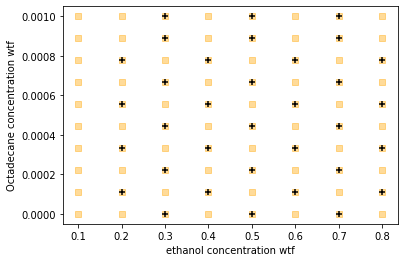

In [10]:
ographing.xy_scatter_df_compare(complete_df, complete_df_filtered, 'ethanol concentration wtf', 'Octadecane concentration wtf')

### Step 6 (Optional): Calculate Stock Prep Information

We can calculate stock information to make it easier to prepare these stock. This process if semi-general, currently supporting a few stock concentration units = mgperml, volf, wtf, molf and molarity. All of these require the basis of volume as that is what is driving how much sample we make for the OT2. 

The logic behind this relies on the notation of stocks = solute1-solute2-....solvent. Using notations allows for systematic handling of solutes and solvent determining what is needed based on information from a excel based Chemical Database.

*Reccomended*: Use at the minimum the default buffering (extra stock being made) of 40 percent to ensure you do not aspirate any air by mistake.

BROKEN FIXING

In [11]:
# stock_volumes = CreateSamples.isolate_common_column(complete_df_filtered, 'stock')
# chem_database_path = r"Chemical Database.xlsx"
# stock_prep_df = CreateSamples.calculate_stock_prep_df(plan, stock_volumes, chem_database_path, buffer_pct=50)
# stock_prep_df
stock_volumes = CreateSamples.isolate_common_column(complete_df_filtered,'stock').sum(axis=0)/1000
stock_volumes

Octadecane-ethanol-stock amount volume uL     4.026667
SDS-ethanol-stock amount volume uL            2.040000
ethanol-stock amount volume uL               19.834956
water-stock amount volume uL                 20.359467
dtype: float64

### Step 8: Simulate/Execute
The main information needed to create commands for the OT2 is the position of the stocks and the volumes in respect to each well you would like to move the stock to. All volumes in sent to the OT2 will be interpretted as microliters (uL). 

* Pipetting Strategy 1: Add each stock to all wells then move onto next stock. The upside to this is the simplicity of the written protocol. It has a downside of using more tips. It can allow for evaporation or other time sensitve process to occur in the time between stock additions. This is referred to component wise pipetting.

* Pipetting Strategy 2: Adding all stocks to a ONE well then moving on, this is referred to as sample wise pipetting. 

### Step 8a Optional: Load custom labware dictionary (Remote Testing)
* Provide the path to the directory holding all custom labware. This directory should have custom labware .json files you have previously made and tested, read more here: https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions
* The reason we provide this is when working on a device that is not connected to the OT2's Jupyter notebook there is no way to natively use custom labware. So we create a dictionary of custom labware so we can later load into our protocol to primarily simualte and test protocols for execution later once connnected to the OT2's notebook.
    * When using custom labware on the OT2's notebook it pulls from a folder labeled "labware", which is something built into the Opentrons hardware. It has not been tested if the custom labware dictionary will superceed this directory of custom labware if used on the OT2.
    * The custom labware folder should contain everything the OT2 labware folder contains: ADD GDRIVE link to customize
    
* **NOTE: Any function using the custom_labware_dict, the argument is optional so can remove and should receive same output IF working on OT2 computer.**

Just noted: transfer_info will fail if transfer and distribute used together, well not fail jsut need to concat

In [12]:
labware_dir_path = r"Custom Labware"
custom_labware_dict = ALH.custom_labware_dict(labware_dir_path)
custom_labware_dict.keys()

dict_keys(['Custom Labware\\20mlscintillation_12_wellplate_18000ul\\20mlscintillation_12_wellplate_18000ul', 'Custom Labware\\abgene_96_wellplate_2200ul\\abgene_96_wellplate_2200ul', 'Custom Labware\\agilent_6_reservoir_47000ul\\agilent_6_reservoir_47000ul', 'Custom Labware\\falcon_48_wellplate_1500ul\\falcon_48_wellplate_1500ul', 'Custom Labware\\fischer_24_wellplate_7400ul\\fischer_24_wellplate_7400ul\\fischer_24_wellplate_7400ul', 'Custom Labware\\nanosampler_48_wellplate_1650ul\\nanosampler_48_wellplate_1650ul'])

### Step 9: Set up Loaded Dictionary and Directions for Volume Handling
It is important to know how many stock container will be needed for each stock and be able to provide the correct instructions for OT2 commands to follow.

The ranges of stock refers to the ranges of wells one stock will cover. The range is provided in terms of the index of the stock volume dataframe i.e.([lower, upper])). The format is as follows = [[stock1_range1, stock1_range2....], [stock2_range1, stock2_range2....] []...]. 

The range is based on the provided maximum volume for each container, since variabiltiy exist between filling it is **HIGHLY RECCOMENDED** to underestimate the total volume of stock a container can hold so for a 20mL scitillation vials 16000-17000 should be use as the max. Another reason for this is the OT2 will do its best to pick up as much volume as possible but understand liquid in vials can coat the sides not leaving enough depth for the OT2 to grab, so it is **HIGHLY RECCOMENDED** to have at least a **15-20%** volume buffer for each stock

The basis of range is on the maximum volume of the stock container, however currently limitation are: 
 * All stock containers must be the same

In [13]:
importlib.reload(ALH)

<module 'Prepare.OT2Commands' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\PlanPrepareProcess\\Prepare\\OT2Commands.py'>

In [14]:
protocol = simulate.get_protocol_api('2.8', extra_labware=custom_labware_dict)
loaded_dict = ALH.loading_labware(protocol, plan, well_order='row')
# ALH.add_labware_to_dict(loaded_dict, 'Destination Wells', ['agilent_6_reservoir_47000ul','agilent_6_reservoir_47000ul'], [5,6])
stock_position_info = ALH.stock_well_ranges(complete_df_filtered, loaded_dict['Stock Wells'])
# water = ALH.stock_well_ranges(complete_df_filtered['water-stock amount volume uL'], loaded_dict['Stock Wells Large'])
# ethanol = ALH.stock_well_ranges(complete_df_filtered['ethanol-stock amount volume uL'], loaded_dict['Stock Wells Large'])

# stock_position_info.update(water)
# stock_position_info.update(ethanol)

C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults
C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults


In [15]:
# ALH.add_labware_to_dict(loaded_dict, 'Cleaning Wells', ['agilent_6_reservoir_47000ul'], [9])
# ALH.cleaning_tip_protocol(loaded_dict, 2) # can do something like this to add other kwargs prior and after trasnfer

In [16]:
directions = ALH.create_sample_making_directions(complete_df_filtered, stock_position_info, loaded_dict, start_position=36)
directions

{0: {'Octadecane-ethanol-stock amount volume uL': {'Stock Position': A1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1,
   'Destination Well Position': D1 of Abgene 96 Well Plate 2200 ÂµL on 2,
   'Stock Volume': 0.0},
  'SDS-ethanol-stock amount volume uL': {'Stock Position': A2 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1,
   'Destination Well Position': D1 of Abgene 96 Well Plate 2200 ÂµL on 2,
   'Stock Volume': 59.99999999999999},
  'ethanol-stock amount volume uL': {'Stock Position': A3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1,
   'Destination Well Position': D1 of Abgene 96 Well Plate 2200 ÂµL on 2,
   'Stock Volume': 396.86782366449575},
  'water-stock amount volume uL': {'Stock Position': B1 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1,
   'Destination Well Position': D1 of Abgene 96 Well Plate 2200 ÂµL on 2,
   'Stock Volume': 839.4000000000001}},
 1: {'Octadecane-ethanol-stock amount volume uL': {'Stock Position': A1 of 20mLscintillation 12 Well Plate 1

In [31]:
ALH.pipette_volumes_sample_wise(protocol, directions, loaded_dict, reuse_tips= True, clean_tips=True, touch_tip = True)

KeyError: 'Cleaning Protocol'

### Step 10: Format for Exporting and Upload to Google Drive
* Using the information from our previously created dataframes we create a final dataframe to convert to a csv and upload to google drive for storage. 
    * Currently the two main pieces of information uploaded are composition of sample and sample location information. This for each sample is tied to a unique ID which contains a well_timestamp_keyword. 

* Currently the function *CreateSamples.add_final_location* uses direciton information plus the sampling dataframe either created or imported to add useful information and export as a csv.

In [17]:
export_path = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Temp or Working\07_29_21_Octadecane_Info_pt2"
export_df = CreateSamples.add_final_location(directions,complete_df_filtered)
# export_df.to_csv(export_path, index = False)
export_df.reset_index(inplace=True, drop=True)
export_df

,UID,Labware,Slot,Well,Octadecane concentration wtf,SDS concentration wtf,ethanol concentration wtf,water concentration wtf,Octadecane amount mass g,Octadecane amount volume uL,...,SDS amount volume uL,ethanol amount mass g,ethanol amount volume uL,water amount mass g,water amount volume uL,Octadecane-ethanol-stock amount volume uL,SDS-ethanol-stock amount volume uL,ethanol-stock amount volume uL,water-stock amount volume uL,Total Volume
0,S2_D1_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D1,0.000000,0.0005,0.3,0.699500,0.000000,0.000000,...,0.594059,0.36,456.100342,0.839400,839.400000,0.000000,60.0,396.867824,839.400000,1296.267824
1,S2_D2_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D2,0.000000,0.0005,0.5,0.499500,0.000000,0.000000,...,0.594059,0.60,760.167237,0.599400,599.400000,0.000000,60.0,701.050333,599.400000,1360.450333
2,S2_D3_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D3,0.000000,0.0005,0.7,0.299500,0.000000,0.000000,...,0.594059,0.84,1064.234132,0.359400,359.400000,0.000000,60.0,1005.232843,359.400000,1424.632843
3,S2_D4_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D4,0.000111,0.0005,0.2,0.799389,0.000133,0.171600,...,0.594059,0.24,304.066895,0.959267,959.266667,26.666667,60.0,218.281502,959.266667,1264.214836
4,S2_D5_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D5,0.000111,0.0005,0.4,0.599389,0.000133,0.171600,...,0.594059,0.48,608.133789,0.719267,719.266667,26.666667,60.0,522.464012,719.266667,1328.397345
5,S2_D6_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D6,0.000111,0.0005,0.6,0.399389,0.000133,0.171600,...,0.594059,0.72,912.200684,0.479267,479.266667,26.666667,60.0,826.646521,479.266667,1392.579855
6,S2_D7_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D7,0.000111,0.0005,0.8,0.199389,0.000133,0.171600,...,0.594059,0.96,1216.267579,0.239267,239.266667,26.666667,60.0,1130.829031,239.266667,1456.762364
7,S2_D8_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D8,0.000222,0.0005,0.3,0.699278,0.000267,0.343200,...,0.594059,0.36,456.100342,0.839133,839.133333,53.333333,60.0,343.877691,839.133333,1296.344357
8,S2_D9_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D9,0.000222,0.0005,0.5,0.499278,0.000267,0.343200,...,0.594059,0.60,760.167237,0.599133,599.133333,53.333333,60.0,648.060200,599.133333,1360.526867
9,S2_D10_08-02-2021,Abgene 96 Well Plate 2200 ÂµL,2,D10,0.000222,0.0005,0.7,0.299278,0.000267,0.343200,...,0.594059,0.84,1064.234132,0.359133,359.133333,53.333333,60.0,952.242710,359.133333,1424.709376


In [19]:
export_df.to_csv(export_path, index=False)

In [ ]:
def function(arg1, **kwargs):
    print(arg1)
    for key, value in kwargs.items():
        print("{0} = {1}".format(key, value))

In [ ]:
function(1, hi = 'touch_tip')